In [20]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import math
import numpy as np
from scipy import stats

In [21]:
# HIDDEN
def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

The functions we have defined so far compute their outputs directly from their inputs. Their return values can be computed from their arguments. However, some functions require additional data to deterimine their return values.

Let's start with a simple example. Consider the following three functions that all scale their input by a constant factor.

In [3]:
def double(x):
    return 2 * x

def triple(x):
    return 3 * x

def halve(x):
    return 0.5 * x

[double(4), triple(4), halve(4), double(5), triple(5), halve(5)]

[8, 12, 2.0, 10, 15, 2.5]

Rather than defining each of these functions with a separate `def` statement, it is possible to generate each of them dynamically by passing in a constant to a generic `scale_by` function.

In [4]:
def scale_by(a):
    def scale(x):
        return a * x
    return scale

double = scale_by(2)
triple = scale_by(3)
halve = scale_by(0.5)
        
[double(4), triple(4), halve(4), double(5), triple(5), halve(5)]

[8, 12, 2.0, 10, 15, 2.5]

The body of the `scale_by` function actually defines a new function, called `scale`, and then returns it. The return value of `scale_by` is a function that takes a number `x` and multiplies it by `a`. Because `scale_by` is a function that returns a function, it is called a *higher-order function*.

The purpose of higher-order functions is to create functions that combine data with behavior. Above, the `double` function is created by combining the data value `2` with the behavior of scaling by a constant.

A `def` statement within another `def` statement behaves in the same way as any other `def` statement *except* that:
1. The name of the inner function is only accessible within the outer function's body. For example, it is not possible to use the name `scale` once `scale_by` has returned.
1. The body of the inner function can refer to the arguments and names within the outer function. So, for example, the body of the inner `scale` function can refer to `a`, which is an argument of the outer function `scale_by`.

The final line of the outer `scale_by` function is `return scale`. This line returns the *function* that was just defined. The purpose of returning a function is to give it a name. The line

    double = scale_by(2)
    
gives the name `double` to the particular instance of the `scale` function that has `a` assigned to the number 2. Notice that it is possible to keep multiple instances of the `scale` function around at once, all with different names such as `double` and `triple`, and Python keeps track of which value for `a` to use each time one of these functions is called.

## Example: Standard Units

We have seen how to convert a list of numbers to standard units by subtracting the mean and dividing by the standard deviation.

In [5]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

This function can convert any list of numbers to standard units.

In [6]:
observations = [3, 4, 2, 4, 3, 5, 1, 6]
np.round(standard_units(observations), 3)

array([-0.333,  0.333, -1.   ,  0.333, -0.333,  1.   , -1.667,  1.667])

How would we answer the question, "what is the number 8 (in original units) converted to standard units?"

Adding 8 to the list of `observations` and re-computing `standard_units` does *not* answer this question, because adding an observation changes the scale!

In [7]:
observations_with_eight = [3, 4, 2, 4, 3, 5, 1, 6, 8]
standard_units(observations_with_eight)

array([-0.5,  0. , -1. ,  0. , -0.5,  0.5, -1.5,  1. ,  2. ])

If instead we want to maintain the original scale, we need a function that remembers the original mean and standard deviation. This scenario, where both data and behavior are required to arrive at the answer, is a natural fit for a higher-order function.

In [8]:
def converter_to_standard_units(any_numbers):
    """Return a function that converts to the standard units of any_numbers."""
    mean = np.mean(any_numbers)
    sd = np.std(any_numbers)
    def convert(a_number_in_original_units):
        return (a_number_in_original_units - mean) / sd
    return convert

Now, we can use the original list of numbers to create the conversion function. The mean and standard deviation are stored within the function that is returned, called `to_su` below. What's more, these numbers are only computed once, no matter how many times we call the function.

In [9]:
observations = [3, 4, 2, 4, 3, 5, 1, 6]
to_su = converter_to_standard_units(observations)
[to_su(2), to_su(3), to_su(8)]

[-1.0, -0.33333333333333331, 3.0]

A complementary function that returns a converter from standard units to original units involves multipying by the standard deviation, then adding the mean.

In [10]:
def converter_from_standard_units(any_numbers):
    """Return a function that converts from the standard units of any_numbers."""
    mean = np.mean(any_numbers)
    sd = np.std(any_numbers)
    def convert(in_standard_units):
        return in_standard_units * sd + mean
    return convert

from_su = converter_from_standard_units(observations)
from_su(3)

8.0

It should be the case that any number converted to standard units and back, using the same list to create both functions. 

In [11]:
from_su(to_su(11))

11.0

## Example: Prediction

Previously, in order to compute the fitted values for a regression, we first computed the slope and intercept of the regression line. As an alternate implementation, for each `x`, we can convert `x` to standard units from the original units of `x` values, then multiply by `r`, then convert the result to the original units of `y` values. We can write down this process as a higher-order function.

In [12]:
def regression_estimator(table, x, y):
    """Return an estimator for y as a function of x."""
    to_su = converter_to_standard_units(table.column(x))
    from_su = converter_from_standard_units(table.column(y))
    r = correlation(table, x, y)
    def estimate(any_x):
        return from_su(r * to_su(any_x))
    return estimate

The following dataset of mothers and babies was collected from the Kaiser Hospital in Oakland, California. 

In [14]:
baby = Table.read_table('baby.csv')
baby

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


Gestational days are the number of days that the mother is pregnant. Most pregnancies last between 250 and 310 days.

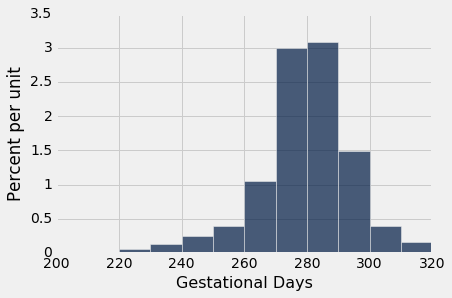

In [16]:
baby.hist(1, bins=np.arange(200, 330, 10))

For this collection of typical births, gestational days and birth weight appear to be linearly related.

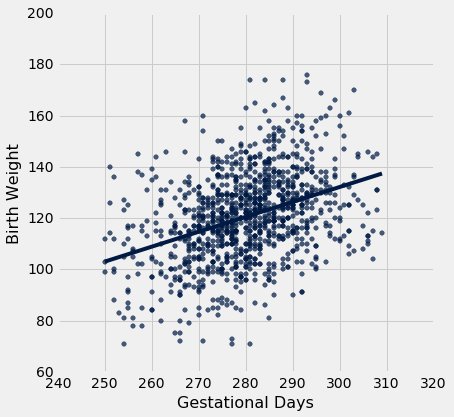

In [18]:
typical = baby.where(np.logical_and(baby.column(1) >= 250, baby.column(1) < 310))
typical.scatter(1, 0, fit_line=True)

The function `average_weight` returns the average weight of babies born after a certain number of gestational days, using the regression line to predict this value. This function is defined within `regression_estimator` and returned. The returned value is bound to the name `average_weight` using an assignment statement.

In [25]:
average_weight = regression_estimator(typical, 1, 0)

The `average_weight` function contains all the information needed to make birth weight predictions, but when it is called, it takes only a single argument: the gestational days. We avoid the need to pass the table and column labels into the `average_weight` function each time that we call it because those values were passed to `regression_estimator`, which defined the `average_weight` function in terms of those values.

In [26]:
average_weight(290)

126.33785752202166

This function is quite flexible. For instance, we can compute fitted values for all gestational days by applying it to the column of gestational days.

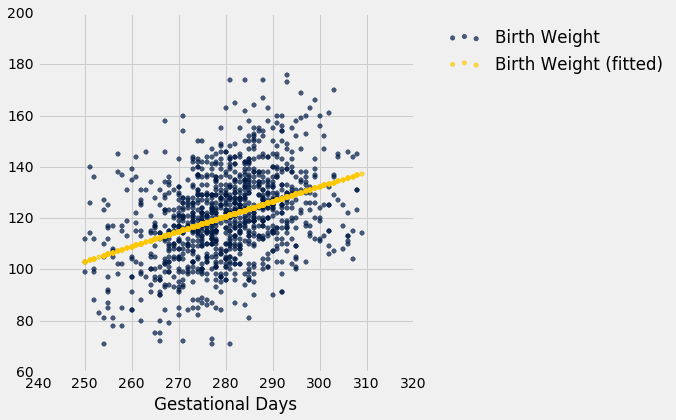

In [27]:
fitted = typical.apply(average_weight, 1)
typical.select([1, 0]).with_column('Birth Weight (fitted)', fitted).scatter(0)

Higher-order functions appear often in the context of prediction because estimating a value often involves both data to inform the prediction and a procedure that makes the prediction itself.